# Preamble 
This contains all the extra stuff. If the environment doesn't contain the qutip and qutip_qip packages, make sure to install them before.

In [4]:
# configure some visualisations
from pytket.circuit.display import get_circuit_renderer
circuit_renderer = get_circuit_renderer()
circuit_renderer.set_render_options(zx_style=False)
circuit_renderer.set_render_options(crop_params=False)
circuit_renderer.save_render_options()
from pytket.utils import QubitPauliOperator
from pytket.pauli import Pauli, QubitPauliString
import networkx as nx
from pytket.circuit import Qubit
from pytket import Circuit
from sympy import symbols
from pytket.circuit.display import render_circuit_jupyter as draw
from pytket.utils import gen_term_sequence_circuit
from pytket.passes import DecomposeBoxes
import numpy as np
def get_xxz_chain_hamiltonian(n_qubits: int, Delta_ZZ: float) -> QubitPauliOperator:
    sites = nx.path_graph(n_qubits)
    qpo_dict = {}
    for e in sites.edges:
        zz_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Z, Pauli.Z])
        xx_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.X, Pauli.X])
        yy_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Y, Pauli.Y])
        qpo_dict[zz_term] = Delta_ZZ
        qpo_dict[xx_term] = 1.0
        qpo_dict[yy_term] = 1.0
    return QubitPauliOperator(qpo_dict)
from pytket.extensions.qiskit import AerStateBackend 
import matplotlib.pyplot as plt
import qutip as qt
from qutip.qip.operations import hadamard_transform, phasegate
import scipy
#from matplotlib import pyplot as plt
from pytket.utils.expectations import get_operator_expectation_value
from pytket.extensions.qiskit import AerBackend
import time

aer_sim = AerBackend()

# Section 0
### <u> Task 1: Implement the time evolution under $XXZ$ Hamiltonian </u>

Here we implement XXZ Hamiltonian in two ways. 

In the first implementation, we use the inbuilt function to create the circuit and run the simulation. 

In the second implementation, we build the circuit from scratch using XXPhase, YYPhase and ZZPhase gates


##### Implementation 1 - Using built-in function

In [5]:
n_qubits = 8
Delta_ZZ = 0.5
t = 1

circ_0 = Circuit(n_qubits)
xxz_ham = get_xxz_chain_hamiltonian(n_qubits=n_qubits, Delta_ZZ=Delta_ZZ)
circ_xxz = gen_term_sequence_circuit(-(2*t/np.pi)*xxz_ham, circ_0)
DecomposeBoxes().apply(circ_xxz)
draw(circ_xxz)
sv_backend = AerStateBackend()
state = (circ_xxz)
#result = sv_backend.run_circuit(state)
#statevector = result.get_state()
#print("Statevector: ", statevector)

##### Implementation 2 - Using quantum gates from scratch

In [6]:
n_qubits = 4
Delta_ZZ = 0.5
t = 1
circ_0 = Circuit(n_qubits)

for ind in range(n_qubits-1):
    circ_0.XXPhase(t*2/np.pi, ind, ind+1)
    circ_0.YYPhase(t*2/np.pi, ind, ind+1)
    circ_0.ZZPhase(Delta_ZZ*t*2/np.pi, ind, ind+1)

DecomposeBoxes().apply(circ_0)
draw(circ_0)
sv_backend = AerStateBackend()
state = (circ_0)
result = sv_backend.run_circuit(state)
statevector = result.get_state()
print("Statevector: ", statevector)

Statevector:  [ 7.07372017e-02-9.97494987e-01j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  4.87156183e-17-2.66134636e-17j
  0.00000000e+00+0.00000000e+00j -1.54074396e-33+2.52380735e-17j
  1.15503950e-17-7.70371978e-34j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]


# Section 1
### <u> Task 1: Implement the transverse field Ising model </u>

Here we give a general implementation of the required hamiltonian for first order trotterization. Specifically, we choose the parameters such that our Hamiltonian is as follows:

$$
\begin{align*}
H = &-1.2(Z_1Z_2 + Z_2Z_3 + Z_3Z_4 + Z_4Z_5 + Z_5Z_6) \\
&+ X_1 + X_2 + X_3 + X_4 + X_5 + X_6 
\end{align*}$$

From here onwards, we will in general implement evolution for $t=1$ for convenience but will always have option to change this parameter.

In [7]:
g = 1
J = 1.2
N = 6 #Number of qubits
t = 1 #Time for which you want to evolve
h = 2 #Number of trotter Steps
ising_circuit = Circuit(N)
for i in range(h):
    for i in range(N):
        ising_circuit.Rx(2*t*g/(np.pi*h), i)
    for i in range(N-1):
        ising_circuit.ZZPhase(-2*J/(np.pi*h), i, i+1)
    ising_circuit.add_barrier(ising_circuit.qubits)
draw(ising_circuit)    

sv_backend = AerStateBackend()
state = (ising_circuit)
result = sv_backend.run_circuit(state)
statevector = result.get_state()
print("Statevector: ", statevector)

Statevector:  [ 0.31057071+0.21051255j -0.2811643 -0.07069088j -0.0550807 +0.02363152j
  0.09311398+0.20440928j -0.10291127+0.09354526j  0.02995425-0.01581208j
  0.0017115 -0.11372609j  0.05947046-0.15934178j -0.10291127+0.09354526j
  0.06940928-0.1172964j   0.0373031 -0.04325709j -0.04929002+0.00741378j
  0.1105957 -0.0392344j  -0.00145946+0.07732752j -0.12043168-0.0060627j
 -0.14065638+0.02474057j -0.0550807 +0.02363152j  0.02995425-0.01581208j
 -0.01301329+0.01167261j -0.04929002+0.00741378j  0.0373031 -0.04325709j
 -0.00739575+0.05188304j -0.02591572-0.01551738j -0.02790875+0.0190934j
  0.0017115 -0.11372609j -0.00145946+0.07732752j -0.02591572-0.01551738j
  0.01154628-0.08239092j -0.12043168-0.0060627j   0.08097545-0.05539828j
  0.03001294+0.05539828j  0.08501127+0.01983343j -0.2811643 -0.07069088j
  0.22425801-0.01271658j  0.02995425-0.01581208j -0.12696318-0.11316752j
  0.06940928-0.1172964j  -0.01095069+0.04862667j -0.00145946+0.07732752j
 -0.02790875+0.14006218j  0.02995425-0.

### <u> Task 2: Trotter error scaling and higher order Trotterization formulas </u>

To get the correct, ideal solution, we make use of qutip and implement classical Simulation by doing explicit matrix-vector multiplication 

In [8]:
#defining useful functions to get operators from strings
I,X,Y,Z,Had,S = qt.qeye(2),qt.sigmax(),qt.sigmay(),qt.sigmaz(),hadamard_transform(),phasegate(np.pi/2)
ket0,ket1=qt.basis(2,0),qt.basis(2,1)
def str2op(string):
    op_dict = {'I':I,'X':X,'Y':Y,'Z':Z,'H':Had,'S':S}
    assert type(string) == str or type(string) == list
    return qt.tensor([op_dict[p] for p in string])

Now, we will construct the hamiltonian matrix from the operator string. Then we start in state $|0\rangle$ and multiply this matrix by doing the appropriate exponentiation of the hamiltonian for time evolution and get the state $|\psi(t)\rangle  = e^{-iHt} |0\rangle$

In [9]:
H = -J*(str2op('ZZIIII')
       +str2op('IZZIII')
       +str2op('IIZZII')
       +str2op('IIIZZI')
       +str2op('IIIIZZ'))+g*(str2op('XIIIII')
       +str2op('IXIIII')
       +str2op('IIXIII')
       +str2op('IIIXII')
       +str2op('IIIIXI')
       +str2op('IIIIIX'))
Psi_0 = qt.tensor([ket0]*N)
H = H.full()
Psi_0 = Psi_0.full()
U = scipy.linalg.expm(-1j * H * t)
Psi_t = U @ Psi_0

Now, we implement 2nd order trotterization. Then we do trotter steps of size 1 to 30 and see the fidelity with the ideal evolution. For the obtained state $|\phi_t\rangle$ for trotter step size $t$ of 2nd order trotterized hamiltonian simulation implementation, we compute $|\langle \phi_t | \psi(t) |^2$

In [10]:
n_trotter_steps = list(range(1, 30))
StateVectors = []

for h in n_trotter_steps:
    ising_circuit = Circuit(N)
    for j in range(h):
        for i in range(N):
            ising_circuit.Rx((2*t*g)/(2*h*np.pi), i)
        for i in range(N-1):
            ising_circuit.ZZPhase((-2*J)/(np.pi*h), i, i+1)
        ising_circuit.add_barrier(ising_circuit.qubits)
        for i in range(N):
            ising_circuit.Rx((2*t*g)/(2*h*np.pi), i)
        ising_circuit.add_barrier(ising_circuit.qubits)
    #draw(ising_circuit)    
    sv_backend = AerStateBackend()
    state = (ising_circuit)
    result = sv_backend.run_circuit(state)
    statevector = result.get_state()
    StateVectors.append(statevector)

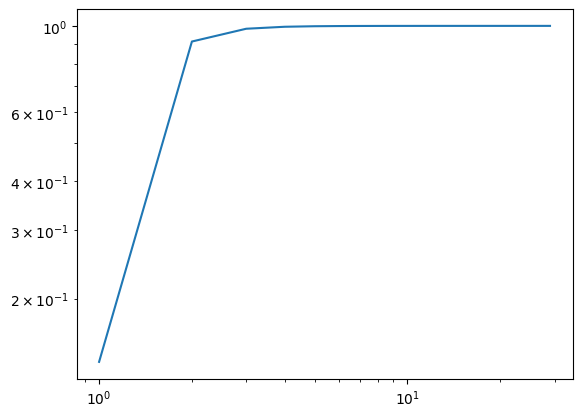

In [11]:
distance = []
for i in StateVectors:
    dist = np.squeeze(Psi_t) @ np.conj(i).T
    distance.append(np.abs(dist)**2)
plt.loglog(n_trotter_steps, distance)


This is the required double log plot. We can observe that as we increase trotter step size, your fidelity improves. Distance with ideal evolution increases monotonically w.r.t. trotter step size. We can see that from the raw data below as well. In the limit $t \to \infty$, We should obtain fidelity 1.

In [12]:
distance

[0.13778361113652876,
 0.9118150026001597,
 0.9832220377501141,
 0.9948162193047735,
 0.9979033834113475,
 0.9989962180812939,
 0.9994606221630467,
 0.9996847672380144,
 0.9998036078759959,
 0.9998713388641619,
 0.9999122200176414,
 0.9999380738914323,
 0.99995506978426,
 0.9999666134456493,
 0.9999746758851982,
 0.9999804445327417,
 0.9999846599425601,
 0.9999877981015939,
 0.9999901731603322,
 0.9999919973814291,
 0.9999934172202205,
 0.9999945356451448,
 0.9999954262900218,
 0.9999961426290985,
 0.999996724045576,
 0.9999971999205594,
 0.9999975924337041,
 0.9999979185117585,
 0.9999981912038757]

### <u> Task 3: Do the same for the XXZ model </u>

We do implemente it for the XXZ model. When we initalize in state $|0\rangle$, we get fidelity 1 with the ideal evolution, which remains constant regardless of the step size. However, when we change it to some different state, whatever fidelity we get still remains a constant less than one regardless of change in trotterization step size.

In [13]:
H = (str2op('XXIIII')
     +str2op('IXXIII')
    +str2op('IIXXII')
    +str2op('IIIXXI')
    +str2op('IIIIXX')
    +str2op('YYIIII')
    +str2op('IYYIII')
    +str2op('IIYYII')
    +str2op('IIIYYI')
    +str2op('IIIIYY'))+Delta_ZZ*(
    str2op('ZZIIII')
    +str2op('IZZIII')
    +str2op('IIZZII')
    +str2op('IIIZZI')
    +str2op('IIIIZZ')
    )
Psi_0 = qt.tensor([ket0]*N)
H = H.full()
Psi_0 = Psi_0.full()
U = scipy.linalg.expm(-1j * H * t)
Psi_t = U @ Psi_0

In [14]:
n_trotter_steps = list(range(1, 30))
StateVectors = []

for h in n_trotter_steps:
    ising_circuit = Circuit(N)
    for i in range(h):
        for ind in range(n_qubits-1):
            circ_0.XXPhase(t*2/(2*np.pi*h), ind, ind+1)
            circ_0.YYPhase(t*2/(2*np.pi*h), ind, ind+1)
            circ_0.ZZPhase(Delta_ZZ*t*2/(h*np.pi), ind, ind+1)
            circ_0.YYPhase(t*2/(2*np.pi*h), ind, ind+1)
            circ_0.XXPhase(t*2/(2*np.pi*h), ind, ind+1)
        #DecomposeBoxes().apply(circ_0)
        # draw(circ_0)
    sv_backend = AerStateBackend()
    state = (ising_circuit)
    result = sv_backend.run_circuit(state)
    statevector = result.get_state()
    StateVectors.append(statevector)

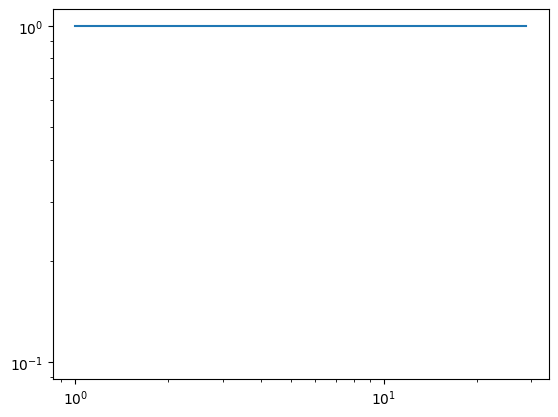

In [15]:
distance = []
for i in StateVectors:
    dist = np.squeeze(Psi_t) @ np.conj(i).T
    distance.append(np.abs(dist)**2)
plt.loglog(n_trotter_steps, distance)


In [16]:
H = (str2op('XXIIII')
     +str2op('IXXIII')
    +str2op('IIXXII')
    +str2op('IIIXXI')
    +str2op('IIIIXX')
    +str2op('YYIIII')
    +str2op('IYYIII')
    +str2op('IIYYII')
    +str2op('IIIYYI')
    +str2op('IIIIYY'))+Delta_ZZ*(
    str2op('ZZIIII')
    +str2op('IZZIII')
    +str2op('IIZZII')
    +str2op('IIIZZI')
    +str2op('IIIIZZ')
    )
Psi_0 = qt.tensor([ket0]*N)
H = H.full()
Psi_0 = Psi_0.full()

#adding extra gates at the start to initialize in a state other than |0>
state_init = str2op('SHIIHI')
state_init = state_init.full()
U = scipy.linalg.expm(-1j * H * t)
Psi_t = U @ state_init @ Psi_0

In [17]:
n_trotter_steps = list(range(1, 30))
StateVectors = []

for h in n_trotter_steps:
    ising_circuit = Circuit(N)
    ising_circuit.S(0)
    ising_circuit.H(1)
    ising_circuit.H(4)
    for i in range(h):
        for ind in range(n_qubits-1):
            circ_0.XXPhase(t*2/(2*np.pi*h), ind, ind+1)
            circ_0.YYPhase(t*2/(2*np.pi*h), ind, ind+1)
            circ_0.ZZPhase(Delta_ZZ*t*2/(h*np.pi), ind, ind+1)
            circ_0.YYPhase(t*2/(2*np.pi*h), ind, ind+1)
            circ_0.XXPhase(t*2/(2*np.pi*h), ind, ind+1)
        #DecomposeBoxes().apply(circ_0)
        # draw(circ_0)
    sv_backend = AerStateBackend()
    state = (ising_circuit)
    result = sv_backend.run_circuit(state)
    statevector = result.get_state()
    StateVectors.append(statevector)


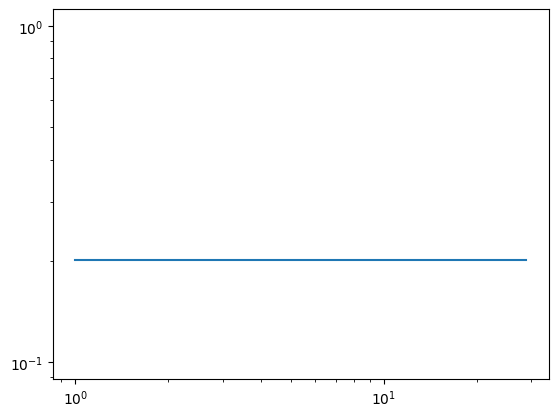

In [18]:
distance = []
for i in StateVectors:
    dist = np.squeeze(Psi_t) @ np.conj(i).T
    distance.append(np.abs(dist)**2)
plt.loglog(n_trotter_steps, distance)



Unfortunately, due to the time constraint, we did not get enough time to investigate this further.

### <u> Task 4: Influence of noise </u>

delete this if we dont have a successful implementation

### <u> Task 5: Other Hamiltonians </u>

Here we implement two other hamiltonians. TODO

# Section 2: Simulating quantum systems
### <u> Task 1: Energy conservation </u>

First we check the energy of the hamiltonian for $|0\rangle^{\otimes N}$, and then check the energy by applying hadamard to only first qubit, and applying hadamard to first and second qubit.

In [19]:
n_qubits = 5
n_shots = 1000
Delta_ZZ = 1.72
xxz_ham = get_xxz_chain_hamiltonian(n_qubits=n_qubits, Delta_ZZ=Delta_ZZ)

initial_state_circtuit = Circuit(n_qubits=n_qubits, name="Initial state")
energy = get_operator_expectation_value(initial_state_circtuit, xxz_ham, aer_sim, n_shots=n_shots)
print("Energy:", energy.real)

initial_state_circtuit.H(0)
energy = get_operator_expectation_value(initial_state_circtuit, xxz_ham, aer_sim, n_shots=n_shots)
print("Energy with H applied to 0:", energy.real)

initial_state_circtuit.H(1)
energy = get_operator_expectation_value(initial_state_circtuit, xxz_ham, aer_sim, n_shots=n_shots)
print("Energy with H applied to 0 and 1:", energy.real)

Energy: 6.857999999999999
Energy with H applied to 0: 5.07712
Energy with H applied to 0 and 1: 4.51008


Now, we implement time evolution for different times specified in the prompt (and more). We plot the number of two qubit gates of the complied and uncomplied circuits while varying the time. We also comute the energy expectation at these points and plot, while keeping track of execution time. We do this for the ising chain hamiltonian.

In [20]:
def get_ising_chain_hamiltonian(n_qubits: int, J: float, g: float) -> QubitPauliOperator:
    sites = nx.path_graph(n_qubits)
    qpo_dict = {}
    for e in sites.edges:
        zz_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Z, Pauli.Z])
        x_term = QubitPauliString([Qubit(e[0])], [Pauli.X])
        qpo_dict[zz_term] = -J
        qpo_dict[x_term] = g

    return QubitPauliOperator(qpo_dict)

t_max = 20
n_shots = 100
times = np.linspace(1, t_max, 21)
trotter_step_size = 3
n_qubits = 5
J = 1.2
g = 1.0

qubit_gates_uncompiled = []
qubit_gates_compiled = []
time_compiled = []
energies = []
circs_compiled = []

ising_ham = get_ising_chain_hamiltonian(n_qubits=n_qubits, J=J, g=g)
for t in times:
    n_steps = int(t//trotter_step_size)
    t_rem = t - n_steps*trotter_step_size
    time_evolution_circ = Circuit(n_qubits)
    for ind in range(n_steps):
        time_evolution_circ = gen_term_sequence_circuit(-(2*trotter_step_size/(np.pi))*ising_ham, time_evolution_circ)
    time_evolution_circ = gen_term_sequence_circuit(-(2*t_rem/(np.pi))*ising_ham, time_evolution_circ)
    DecomposeBoxes().apply(time_evolution_circ)
    qubit_gates_uncompiled.append(time_evolution_circ.n_2qb_gates())
    time_evolution_circ_compiled = aer_sim.get_compiled_circuit(time_evolution_circ, optimisation_level = 2)
    circs_compiled.append(time_evolution_circ_compiled)
    qubit_gates_compiled.append(time_evolution_circ_compiled.n_2qb_gates())
    start = time.time()
    energy = get_operator_expectation_value(time_evolution_circ_compiled, ising_ham, aer_sim, n_shots=n_shots)
    end = time.time()
    energies.append(energy.real)
    time_compiled.append(end-start)

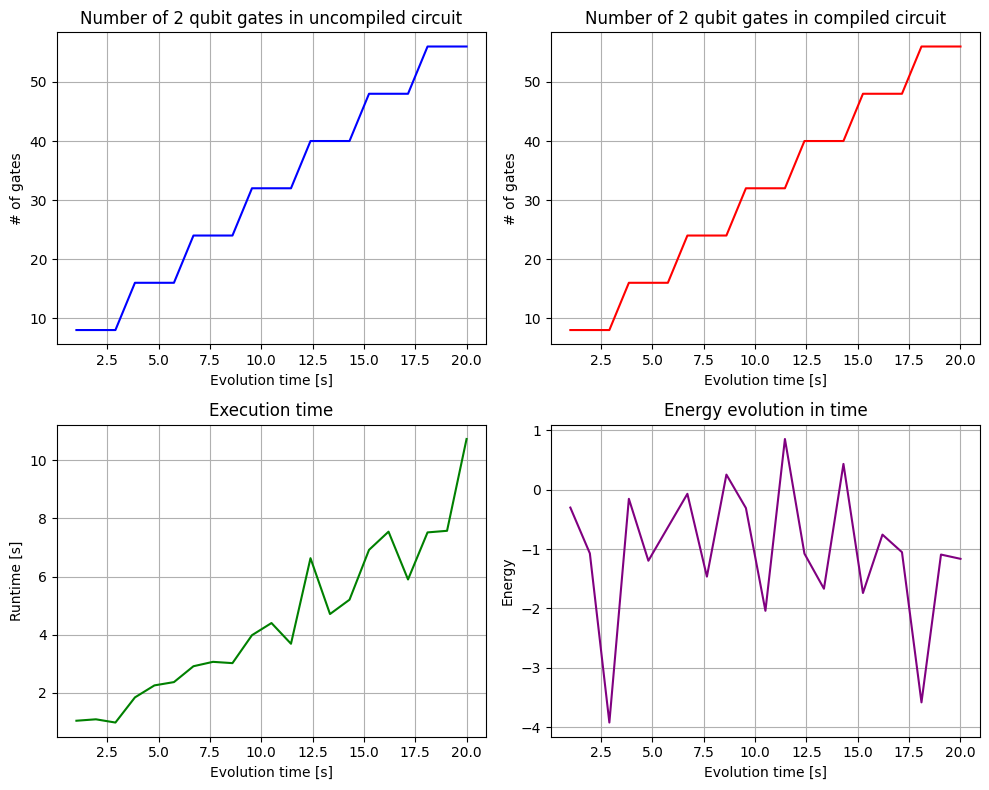

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes[0, 0].plot(times, qubit_gates_uncompiled, color="blue")
axes[0, 0].set_title("Number of 2 qubit gates in uncompiled circuit")
axes[0, 0].set_xlabel("Evolution time [s]")
axes[0, 0].set_ylabel("# of gates")
axes[0, 0].grid(True)

axes[0, 1].plot(times, qubit_gates_compiled, color="red")
axes[0, 1].set_title("Number of 2 qubit gates in compiled circuit")
axes[0, 1].set_xlabel("Evolution time [s]")
axes[0, 1].set_ylabel("# of gates")
axes[0, 1].grid(True)

axes[1, 0].plot(times, time_compiled, color="green")
axes[1, 0].set_title("Execution time")
axes[1, 0].set_xlabel("Evolution time [s]")
axes[1, 0].set_ylabel("Runtime [s]")
axes[1, 0].grid(True)

axes[1, 1].plot(times, energies, color="purple")
axes[1, 1].set_title("Energy evolution in time")
axes[1, 1].set_xlabel("Evolution time [s]")
axes[1, 1].set_ylabel("Energy")
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

### <u> Task 2: Influence of noise </u>
todo


### <u> Task 3: Hamiltonian system dynamics <u>

Here, we do the same time evolution as before, measure $\langle X_1 \rangle$ and $\langle X_1  X_2\rangle$ at different points, and plot the results. As this hamiltonian also has terms with Pauli X, we do expect both of these observables to change the expectation value, which we can clearly observe below.

In [22]:
x0s = []
x0x1s = []
for ind, t in enumerate(times):
    x0op = QubitPauliOperator({QubitPauliString({Qubit(0): Pauli.X}): 1.0})
    x0 = get_operator_expectation_value(circs_compiled[ind], x0op, aer_sim, n_shots=n_shots)
    x0s.append(x0)

    x0x1op = QubitPauliOperator({QubitPauliString({Qubit(0): Pauli.X, Qubit(1): Pauli.X}): 1.0})
    x0x1 = get_operator_expectation_value(circs_compiled[ind], x0x1op, aer_sim, n_shots=n_shots)
    x0x1s.append(x0x1)

/opt/conda/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/conda/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


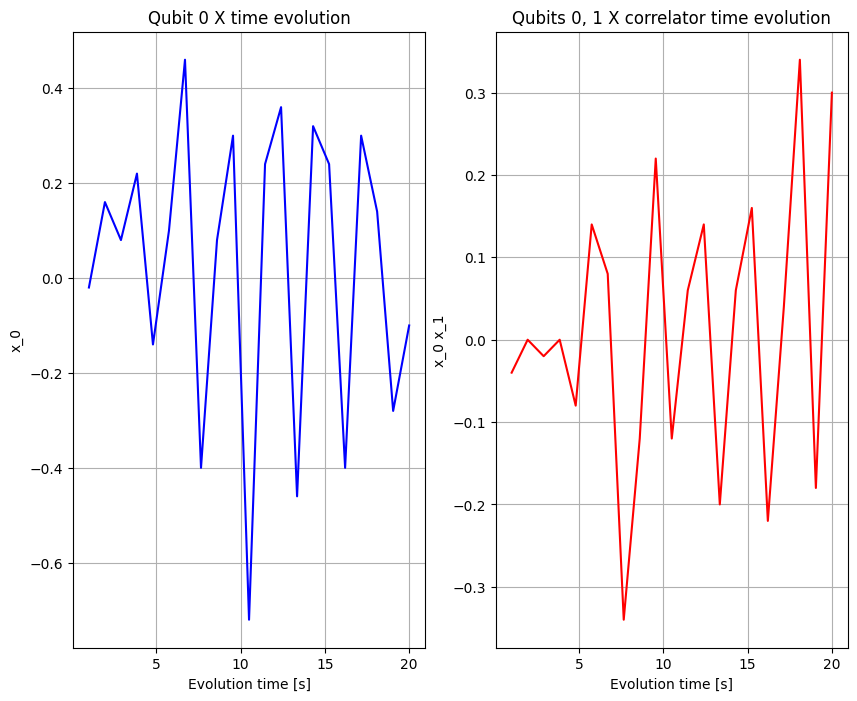

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

axes[0].plot(times, x0s, color="blue")
axes[0].set_title("Qubit 0 X time evolution")
axes[0].set_xlabel("Evolution time [s]")
axes[0].set_ylabel("x_0")
axes[0].grid(True)

axes[1].plot(times, x0x1s, color="red")
axes[1].set_title("Qubits 0, 1 X correlator time evolution")
axes[1].set_xlabel("Evolution time [s]")
axes[1].set_ylabel("x_0 x_1")
axes[1].grid(True)

### <u> Task 4: Hamiltonian system dynamics </u>

Here we work with a simple hamiltonian. 
$$ H = -1.2 Z_1Z_2 + X_1 + X_2$$

We then diagonalize it numerically, compute two different eigenvectors $|a\rangle$, $|b\rangle$ and then using inbuilt functions, intialize our quantum circuit in the state $$|\psi\rangle = \frac{|a\rangle + |b\rangle}{\sqrt{2}}\,.$$ Then we evolve this and compute plot the expectation value $\langle \psi| Z_1 | \psi \rangle$. 

We know that $Z_1$ have two outcomes, +1 and -1. The expectation value will be

$$\langle \psi| Z_1 | \psi \rangle = p(+1)*(+1) + p(-1)*(-1) $$

However, $p(+1)$ is just probability of first qubit being 0, and $p(-1)$ is just $1 - p(+1)$. Then we compute the $p(+1)$ emperically by just adding the modulus square of the first half entries of the state vectors, which all corrospond to first qubit being 0.

In [24]:
from pytket.circuit import StatePreparationBox

z0_expectation = []

H = -J*(str2op('ZZ')) + g*(str2op('XI')+str2op('IX'))
eigenvalues, eigenvectors = H.eigenstates()

a = eigenvectors[0].full()
b = eigenvectors[1].full()
N=2

for t in range(1, 10):
    new_state = (a+b)/np.sqrt(2)
    circuit = Circuit(2)
    circuit.add_gate(StatePreparationBox(new_state), [0, 1])
    for j in range(h):
        for i in range(N):
            circuit.Rx((2*t*g)/(2*h*np.pi), i)
        for i in range(N-1):
            circuit.ZZPhase((-2*J)/(np.pi*h), i, i+1)
        circuit.add_barrier(circuit.qubits)
        for i in range(N):
            circuit.Rx((2*t*g)/(2*h*np.pi), i)
        circuit.add_barrier(circuit.qubits)
    #draw(circuit)   

    sv_backend = AerStateBackend()
    state = (circuit)
    compiled_circuit = sv_backend.get_compiled_circuit(circuit) 
    result = sv_backend.run_circuit(compiled_circuit)
    statevector = result.get_state()
    p_of_plus1 = abs(statevector[0])**2 + abs(statevector[1])**2
    p_of_minus1 = 1 - p_of_plus1
    z0_expectation.append(p_of_plus1 - p_of_minus1)
z0_expectation


[-0.3699903656718182,
 0.7400431675287524,
 -0.2100958806022541,
 -0.4874076281145343,
 0.5850599403496441,
 -0.01166230902251697,
 -0.5556146784837401,
 0.46825647633924095,
 0.15889996848583365]

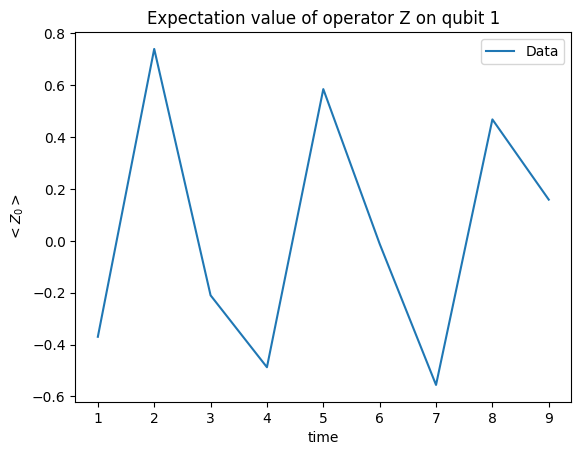

In [25]:
plt.plot(range(1,10), z0_expectation, label='Data'); plt.xlabel('time'); plt.ylabel('$<Z_0>$'); plt.title('Expectation value of operator Z on qubit 1'); plt.legend(); plt.show()

As expected, the expectation value osscilates between $[-1, +1]$. If we had higher energy, the oscillations would be faster. The norm of the hamiltonian will dictate this.

### Task 5: Time evolution of Ising model

As discussed on the discord, due to XXZ hamiltonian being non-commuting type, we did implementation of the above tasks already for the ising model instead of XXZ, and hence we have finished this task.